In [53]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [41]:
# read in data
fname = 'bank/bank-full.csv'

columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = pd.read_csv(fname, delimiter=';')
df = df[columns]

In [42]:
from sklearn.model_selection import train_test_split

# Split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['y']
y_val = df_val['y']
y_test = df_test['y']

del df_train['y']
del df_val['y']
del df_test['y']

### Q1

In [43]:
from sklearn.metrics import roc_auc_score

numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']


# Loop through each numerical feature and calculate AUC values
auc_scores = {}
for feature in numerical:
    score = df_train[feature]  
    auc = roc_auc_score(y_train, score)  
    if auc<0.5:
        score = -df_train[feature]
        auc = roc_auc_score(y_train, score)  
    auc_scores[feature] = auc  

# Convert the results to a dataframe 
auc_df = pd.DataFrame(auc_scores.items(), columns=['Feature', 'AUC'])
auc_df.sort_values(by='AUC', inplace=True)

# Display the AUC values
print(auc_df)

    Feature       AUC
0       age  0.512186
2       day  0.525958
4  campaign  0.571454
1   balance  0.588831
5     pdays  0.590128
3  duration  0.814700


### Q2

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

def one_hot_encode(X):
    """
    One hot encode features with DictVectorizer
    """
    # Intantiate a vectorizer
    vectorizer = DictVectorizer(sparse=False)
    
    # Convert the dataframe into a list of dictionaries (row-wise)
    X_dict = X.to_dict(orient='records')

    # Fit and transform the data to apply one-hot encoding
    X_encoded = vectorizer.fit_transform(X_dict)

    return X_encoded

In [45]:
# Train a logistic regression model
X_train_encoded = one_hot_encode(df_train)
X_val_encoded = one_hot_encode(df_val)

y_train = y_train.map({'yes': 1, 'no': 0})
y_val = y_val.map({'yes': 1, 'no': 0})

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [48]:
# Make predictions
y_val_pred = model.predict(X_val_encoded)

# Compute AUC
auc = roc_auc_score(y_val.values, y_val_pred)
print(f'AUC: {auc:.2f}')

AUC: 0.66


### Q3

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict probabilities on the validation set
y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1] 

# Initialize a list to store evaluation results for each threshold
thresholds = np.arange(0.0, 1.01, 0.01)  
evaluation_results = []

for threshold in thresholds:
    y_pred_binary = (y_val_pred_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_val.values, y_pred_binary).ravel()
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate (Recall)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False positive rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
    accuracy = accuracy_score(y_val.values, y_pred_binary)  # Accuracy
    F1 = 2 * tpr * precision/ (tpr + precision) if (tpr + precision) > 0 else 0
    
    evaluation_results.append({
        'Threshold': threshold,
        'TPR (Recall)': tpr,
        'FPR ': fpr,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': F1
    })

# Convert results to a DataFrame for easy visualization
evaluation_df = pd.DataFrame(evaluation_results)

# Display the evaluation results
print(evaluation_df)

     Threshold  TPR (Recall)      FPR   Precision  Accuracy        F1
0         0.00      1.000000  1.000000   0.121433  0.121433  0.216568
1         0.01      0.996357  0.878902   0.135463  0.227383  0.238500
2         0.02      0.995446  0.728097   0.158936  0.359766  0.274107
3         0.03      0.989982  0.596173   0.186674  0.475006  0.314116
4         0.04      0.972678  0.478726   0.219257  0.576089  0.357849
..         ...           ...       ...        ...       ...       ...
96        0.96      0.027322  0.002140   0.638298  0.880004  0.052402
97        0.97      0.022769  0.001888   0.625000  0.879673  0.043937
98        0.98      0.019126  0.001259   0.677419  0.879783  0.037201
99        0.99      0.009107  0.000629   0.666667  0.879120  0.017969
100       1.00      0.000000  0.000000   0.000000  0.878567  0.000000

[101 rows x 6 columns]


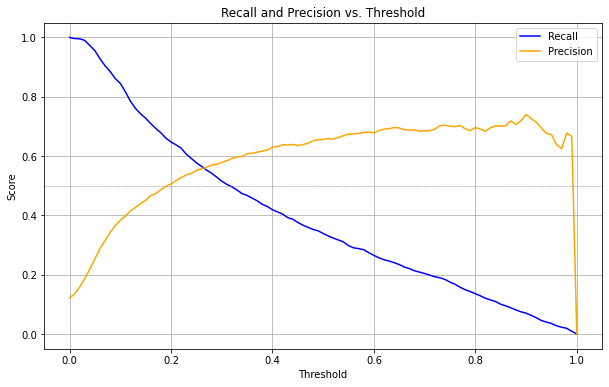

Threshold at intersection of Recall and Precision: 0.260


In [40]:
import matplotlib.pyplot as plt

# Plot Recall and Accuracy
plt.figure(figsize=(10, 6))
plt.plot(evaluation_df['Threshold'], evaluation_df['TPR (Recall)'], label='Recall', color='blue')
plt.plot(evaluation_df['Threshold'], evaluation_df['Precision'], label='Precision', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall and Precision vs. Threshold')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.5)  # Optional horizontal line at 0.5 for reference
plt.legend()
plt.grid()
plt.show()

# Find the threshold where Recall and Accuracy intersect
intersection_index = np.argwhere(np.isclose(evaluation_df['TPR (Recall)'].values.tolist(), evaluation_df['Precision'].values.tolist(), atol=1e-2)).flatten()
if intersection_index.size > 0:
    intersection_threshold = evaluation_df.loc[intersection_index, 'Threshold'].values[0]
    print(f'Threshold at intersection of Recall and Precision: {intersection_threshold:.3f}')
else:
    print('No intersection found within the defined threshold range.')

### Q4

In [38]:
# Find the threshold where F1 is maximum
max_index = evaluation_df['F1'].idxmax()

# Use the index to find the corresponding value in column 'B'
max_threshold = evaluation_df.loc[max_index, 'Threshold']

print(f'Threshold at F1 maximum: {max_threshold:.2f}')

Threshold at F1 maximum: 0.22


### Q5

In [49]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [50]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [51]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [54]:
n_splits = 5
C = 1.0

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1.0 0.903 +- 0.006


### Q6

In [56]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.824 +- 0.009
C=0.001 0.882 +- 0.013
C=1 0.903 +- 0.006
